# YZV 411E - Big Data Analytics - Project - Flight Volume and Delay Analysis using Big Data Approach

- Yusuf Faruk Güldemir - 150210302
- Burak Ercan - 150220749
- Emirhan Gazi - 150220757

## Importing Libraries

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import col, when, hour, month, dayofweek, isnull, count, mean, stddev, udf, to_date, avg, rank
from pyspark.sql.types import IntegerType, FloatType, StringType, DoubleType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import os
import matplotlib.pyplot as plt

from utils import *

%reload_ext autoreload
%autoreload 2

## Spark Session Initialization

In [ ]:
spark = (SparkSession.builder
         .appName("YZV411E Project")
         .config("spark.driver.memory", "8g")
         .config("spark.executor.memory", "16g")
         .getOrCreate())

In [ ]:
spark.version

## Loading Data and Getting to Know the Data

### 2016

In [ ]:
df_2016 = spark.read.csv("data/2016.csv", header=True, inferSchema=True)

In [ ]:
df_2016.printSchema()
print("-"*50)
df_2016.show(5)
print("-"*50)
df_2016.describe().show()
print("-"*50)

root
 |-- FL_DATE: date (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: doub

25/01/04 22:58:54 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|

+-------+----------+------------------+-------+-------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+--------------------+-----------------+--------------------+------------------+-------------------+------------------+-----------------+-----------------+------------------+------------------+-------------------+-------------------+-----------+
|summary|OP_CARRIER| OP_CARRIER_FL_NUM| ORIGIN|   DEST|     CRS_DEP_TIME|          DEP_TIME|        DEP_DELAY|         TAXI_OUT|       WHEELS_OFF|         WHEELS_ON|          TAXI_IN|      CRS_ARR_TIME|         ARR_TIME|         ARR_DELAY|           CANCELLED|CANCELLATION_CODE|            DIVERTED|  CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|          AIR_TIME|         DISTANCE|    CARRIER_DELAY|     WEATHER_DELAY|         NAS_DELAY|     SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|
+-------+----------+------------

In [ ]:
summary_df_2016 = calculate_null_statistics(spark, df_2016)
summary_df_2016.show()

+-------------------+----------+---------------+
|             Column|Null Count|Null Percentage|
+-------------------+----------+---------------+
|            FL_DATE|         0|            0.0|
|         OP_CARRIER|         0|            0.0|
|  OP_CARRIER_FL_NUM|         0|            0.0|
|             ORIGIN|         0|            0.0|
|               DEST|         0|            0.0|
|       CRS_DEP_TIME|         0|            0.0|
|           DEP_TIME|     63456|           1.13|
|          DEP_DELAY|     63456|           1.13|
|           TAXI_OUT|     65418|           1.16|
|         WHEELS_OFF|     65418|           1.16|
|          WHEELS_ON|     67844|           1.21|
|            TAXI_IN|     67844|           1.21|
|       CRS_ARR_TIME|         0|            0.0|
|           ARR_TIME|     67844|           1.21|
|          ARR_DELAY|     79513|           1.42|
|          CANCELLED|         0|            0.0|
|  CANCELLATION_CODE|   5551797|          98.83|
|           DIVERTED

### 2017

In [ ]:
df_2017 = spark.read.csv("data/2017.csv", header=True, inferSchema=True)

In [ ]:
df_2017.printSchema()
print("-"*50)
df_2017.show(5)
print("-"*50)
df_2017.describe().show()
print("-"*50)

root
 |-- FL_DATE: date (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: doub

+-------+----------+-----------------+-------+-------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+--------------------+-----------------+--------------------+-----------------+-------------------+------------------+-----------------+-----------------+------------------+------------------+-------------------+-------------------+-----------+
|summary|OP_CARRIER|OP_CARRIER_FL_NUM| ORIGIN|   DEST|      CRS_DEP_TIME|          DEP_TIME|        DEP_DELAY|          TAXI_OUT|        WHEELS_OFF|         WHEELS_ON|          TAXI_IN|     CRS_ARR_TIME|          ARR_TIME|        ARR_DELAY|           CANCELLED|CANCELLATION_CODE|            DIVERTED| CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|          AIR_TIME|         DISTANCE|    CARRIER_DELAY|     WEATHER_DELAY|         NAS_DELAY|     SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|
+-------+----------+------------

In [ ]:
summary_df_2017 = calculate_null_statistics(spark, df_2017)
summary_df_2017.show()

+-------------------+----------+---------------+
|             Column|Null Count|Null Percentage|
+-------------------+----------+---------------+
|            FL_DATE|         0|            0.0|
|         OP_CARRIER|         0|            0.0|
|  OP_CARRIER_FL_NUM|         0|            0.0|
|             ORIGIN|         0|            0.0|
|               DEST|         0|            0.0|
|       CRS_DEP_TIME|         0|            0.0|
|           DEP_TIME|     80308|           1.42|
|          DEP_DELAY|     80343|           1.42|
|           TAXI_OUT|     82145|           1.45|
|         WHEELS_OFF|     82141|           1.45|
|          WHEELS_ON|     84674|           1.49|
|            TAXI_IN|     84674|           1.49|
|       CRS_ARR_TIME|         0|            0.0|
|           ARR_TIME|     84674|           1.49|
|          ARR_DELAY|     95211|           1.68|
|          CANCELLED|         0|            0.0|
|  CANCELLATION_CODE|   5591928|          98.54|
|           DIVERTED

### 2018

In [ ]:
df_2018 = spark.read.csv("data/2018.csv", header=True, inferSchema=True)

In [ ]:
df_2018.printSchema()
print("-"*50)
df_2018.show(5)
print("-"*50)
df_2018.describe().show()
print("-"*50)

root
 |-- FL_DATE: date (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: doub

+-------+----------+------------------+-------+-------+------------------+------------------+------------------+------------------+------------------+----------------+------------------+-----------------+-----------------+-----------------+-------------------+-----------------+--------------------+------------------+-------------------+------------------+-----------------+-----------------+------------------+------------------+-------------------+-------------------+-----------+
|summary|OP_CARRIER| OP_CARRIER_FL_NUM| ORIGIN|   DEST|      CRS_DEP_TIME|          DEP_TIME|         DEP_DELAY|          TAXI_OUT|        WHEELS_OFF|       WHEELS_ON|           TAXI_IN|     CRS_ARR_TIME|         ARR_TIME|        ARR_DELAY|          CANCELLED|CANCELLATION_CODE|            DIVERTED|  CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|          AIR_TIME|         DISTANCE|    CARRIER_DELAY|     WEATHER_DELAY|         NAS_DELAY|     SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|
+-------+----------+------------

In [ ]:
summary_df_2018 = calculate_null_statistics(spark, df_2018)
summary_df_2018.show()

+-------------------+----------+---------------+
|             Column|Null Count|Null Percentage|
+-------------------+----------+---------------+
|            FL_DATE|         0|            0.0|
|         OP_CARRIER|         0|            0.0|
|  OP_CARRIER_FL_NUM|         0|            0.0|
|             ORIGIN|         0|            0.0|
|               DEST|         0|            0.0|
|       CRS_DEP_TIME|         0|            0.0|
|           DEP_TIME|    112317|           1.56|
|          DEP_DELAY|    117234|           1.63|
|           TAXI_OUT|    115830|           1.61|
|         WHEELS_OFF|    115829|           1.61|
|          WHEELS_ON|    119246|           1.65|
|            TAXI_IN|    119246|           1.65|
|       CRS_ARR_TIME|         0|            0.0|
|           ARR_TIME|    119245|           1.65|
|          ARR_DELAY|    137040|            1.9|
|          CANCELLED|         0|            0.0|
|  CANCELLATION_CODE|   7096862|          98.38|
|           DIVERTED

### 2019

In [ ]:
df_2019 = spark.read.csv("data/2019.csv", header=True, inferSchema=True)

In [ ]:
df_2019.printSchema()
print("-"*50)
df_2019.show(5)
print("-"*50)
df_2019.describe().show()
print("-"*50)

root
 |-- FL_DATE: date (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEP_TIME: integer (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- ARR_TIME: integer (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: double (nullable = true)
 |-- NAS_DELAY: double (nullable = true)
 |-- SECURITY_DELAY: double (nullable = true)
 |-- LATE_AIRCRAFT_DELAY: double (nullable = true)
 |-- _c20: string (nullable = true)

--------------------------------------------------


24/12/28 16:02:34 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: FL_DATE, OP_UNIQUE_CARRIER, OP_CARRIER_FL_NUM, ORIGIN, DEST, DEP_TIME, DEP_DELAY, TAXI_OUT, WHEELS_OFF, WHEELS_ON, TAXI_IN, ARR_TIME, ARR_DELAY, AIR_TIME, DISTANCE, CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY, 
 Schema: FL_DATE, OP_UNIQUE_CARRIER, OP_CARRIER_FL_NUM, ORIGIN, DEST, DEP_TIME, DEP_DELAY, TAXI_OUT, WHEELS_OFF, WHEELS_ON, TAXI_IN, ARR_TIME, ARR_DELAY, AIR_TIME, DISTANCE, CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY, _c20
Expected: _c20 but found: 
CSV file: file:///Users/yusufarukguld/Desktop/2024%20Fall/YZV411E/Project/data/2019.csv


+----------+-----------------+-----------------+------+----+--------+---------+--------+----------+---------+-------+--------+---------+--------+--------+-------------+-------------+---------+--------------+-------------------+----+
|   FL_DATE|OP_UNIQUE_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|ARR_TIME|ARR_DELAY|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|_c20|
+----------+-----------------+-----------------+------+----+--------+---------+--------+----------+---------+-------+--------+---------+--------+--------+-------------+-------------+---------+--------------+-------------------+----+
|2019-01-01|               9E|             3280|   GNV| ATL|     601|      1.0|    22.0|       623|      714|    8.0|     722|     -1.0|    51.0|   300.0|         NULL|         NULL|     NULL|          NULL|               NULL|NULL|
|2019-01-01|               9E|             3281|   MSP| CVG|    1359

24/12/28 16:02:35 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: OP_UNIQUE_CARRIER, OP_CARRIER_FL_NUM, ORIGIN, DEST, DEP_TIME, DEP_DELAY, TAXI_OUT, WHEELS_OFF, WHEELS_ON, TAXI_IN, ARR_TIME, ARR_DELAY, AIR_TIME, DISTANCE, CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY, 
 Schema: OP_UNIQUE_CARRIER, OP_CARRIER_FL_NUM, ORIGIN, DEST, DEP_TIME, DEP_DELAY, TAXI_OUT, WHEELS_OFF, WHEELS_ON, TAXI_IN, ARR_TIME, ARR_DELAY, AIR_TIME, DISTANCE, CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY, _c20
Expected: _c20 but found: 
CSV file: file:///Users/yusufarukguld/Desktop/2024%20Fall/YZV411E/Project/data/2019.csv


+-------+-----------------+------------------+-------+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-------------------+-------------------+----+
|summary|OP_UNIQUE_CARRIER| OP_CARRIER_FL_NUM| ORIGIN|   DEST|          DEP_TIME|         DEP_DELAY|          TAXI_OUT|        WHEELS_OFF|        WHEELS_ON|           TAXI_IN|          ARR_TIME|        ARR_DELAY|          AIR_TIME|         DISTANCE|     CARRIER_DELAY|     WEATHER_DELAY|         NAS_DELAY|     SECURITY_DELAY|LATE_AIRCRAFT_DELAY|_c20|
+-------+-----------------+------------------+-------+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+---------

In [ ]:
summary_df_2019 = calculate_null_statistics(spark, df_2019)
summary_df_2019.show()

24/12/28 16:03:30 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: FL_DATE, OP_UNIQUE_CARRIER, OP_CARRIER_FL_NUM, ORIGIN, DEST, DEP_TIME, DEP_DELAY, TAXI_OUT, WHEELS_OFF, WHEELS_ON, TAXI_IN, ARR_TIME, ARR_DELAY, AIR_TIME, DISTANCE, CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY, 
 Schema: FL_DATE, OP_UNIQUE_CARRIER, OP_CARRIER_FL_NUM, ORIGIN, DEST, DEP_TIME, DEP_DELAY, TAXI_OUT, WHEELS_OFF, WHEELS_ON, TAXI_IN, ARR_TIME, ARR_DELAY, AIR_TIME, DISTANCE, CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY, _c20
Expected: _c20 but found: 
CSV file: file:///Users/yusufarukguld/Desktop/2024%20Fall/YZV411E/Project/data/2019.csv
Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=
24/12/28 16:03:55 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Heade

CodeCache: size=131072Kb used=51240Kb max_used=51240Kb free=79831Kb
 bounds [0x000000010a1e8000, 0x000000010d448000, 0x00000001121e8000]
 total_blobs=17013 nmethods=16060 adapters=864
 compilation: disabled (not enough contiguous free space left)


+-------------------+----------+---------------+
|             Column|Null Count|Null Percentage|
+-------------------+----------+---------------+
|            FL_DATE|         0|            0.0|
|  OP_UNIQUE_CARRIER|         0|            0.0|
|  OP_CARRIER_FL_NUM|         0|            0.0|
|             ORIGIN|         0|            0.0|
|               DEST|         0|            0.0|
|           DEP_TIME|    130086|           1.75|
|          DEP_DELAY|    130110|           1.75|
|           TAXI_OUT|    133977|           1.81|
|         WHEELS_OFF|    133977|           1.81|
|          WHEELS_ON|    137647|           1.85|
|            TAXI_IN|    137647|           1.85|
|           ARR_TIME|    137646|           1.85|
|          ARR_DELAY|    153805|           2.07|
|           AIR_TIME|    153805|           2.07|
|           DISTANCE|         0|            0.0|
|      CARRIER_DELAY|   6032784|          81.28|
|      WEATHER_DELAY|   6032784|          81.28|
|          NAS_DELAY

### 2020

In [ ]:
df_2020 = spark.read.csv("data/2020.csv", header=True, inferSchema=True)

In [ ]:
df_2020.printSchema()
print("-"*50)
df_2020.show(5)
print("-"*50)
df_2020.describe().show()
print("-"*50)

root
 |-- FL_DATE: date (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: integer (nullable = true)
 |-- CRS_ARR_TIME: double (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: double (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: string (nullable = true)
 |-- DISTANCE: string (nullable = true)
 |-- CARRIER_DELAY: string (nullable = true)
 |-- WEATHER_DELAY: st

+-------+----------+------------------+-------+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|summary|OP_CARRIER| OP_CARRIER_FL_NUM| ORIGIN|   DEST|      CRS_DEP_TIME|          DEP_TIME|         DEP_DELAY|          TAXI_OUT|        WHEELS_OFF|         WHEELS_ON|          TAXI_IN|      CRS_ARR_TIME|          ARR_TIME|        ARR_DELAY|         CANCELLED| CANCELLATION_CODE|          DIVERTED|   CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|
+-------+----------+------------------+-------+-------+------------------+------------------+------------------+

In [ ]:
summary_df_2020 = calculate_null_statistics(spark, df_2020)
summary_df_2020.show()

+-------------------+----------+---------------+
|             Column|Null Count|Null Percentage|
+-------------------+----------+---------------+
|            FL_DATE|         0|            0.0|
|         OP_CARRIER|         0|            0.0|
|  OP_CARRIER_FL_NUM|         0|            0.0|
|             ORIGIN|         0|            0.0|
|               DEST|         0|            0.0|
|       CRS_DEP_TIME|    263935|          10.36|
|           DEP_TIME|    263990|          10.36|
|          DEP_DELAY|    264407|          10.38|
|           TAXI_OUT|    264407|          10.38|
|         WHEELS_OFF|    265285|          10.41|
|          WHEELS_ON|    265285|          10.41|
|            TAXI_IN|    265285|          10.41|
|       CRS_ARR_TIME|    268764|          10.55|
|           ARR_TIME|    268764|          10.55|
|          ARR_DELAY|         0|            0.0|
|          CANCELLED|   2295172|          90.09|
|  CANCELLATION_CODE|   2295172|          90.09|
|           DIVERTED

## Data Merging

In [ ]:
df_all = df_2016.union(df_2017).union(df_2018) # 2019 and 2020 are not included. Because 2019 has diffferent columns. 2020 is not added because it is not complete.

In [ ]:
df_all.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: doub

In [ ]:
summary_df_all = calculate_null_statistics(spark, df_all)

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=46994Kb max_used=47006Kb free=84077Kb
 bounds [0x000000010a9e8000, 0x000000010d828000, 0x00000001129e8000]
 total_blobs=16416 nmethods=15464 adapters=862
 compilation: disabled (not enough contiguous free space left)


In [ ]:
summary_df_all.show(summary_df_all.count(), truncate=0)

+-------------------+----------+---------------+
|Column             |Null Count|Null Percentage|
+-------------------+----------+---------------+
|FL_DATE            |0         |0.0            |
|OP_CARRIER         |0         |0.0            |
|OP_CARRIER_FL_NUM  |0         |0.0            |
|ORIGIN             |0         |0.0            |
|DEST               |0         |0.0            |
|CRS_DEP_TIME       |0         |0.0            |
|DEP_TIME           |256081    |1.38           |
|DEP_DELAY          |261033    |1.41           |
|TAXI_OUT           |263393    |1.42           |
|WHEELS_OFF         |263388    |1.42           |
|WHEELS_ON          |271764    |1.47           |
|TAXI_IN            |271764    |1.47           |
|CRS_ARR_TIME       |0         |0.0            |
|ARR_TIME           |271763    |1.47           |
|ARR_DELAY          |311764    |1.68           |
|CANCELLED          |0         |0.0            |
|CANCELLATION_CODE  |18240587  |98.57          |
|DIVERTED           

## Data Preprocessing

### Visualizing Missing Values Percentage

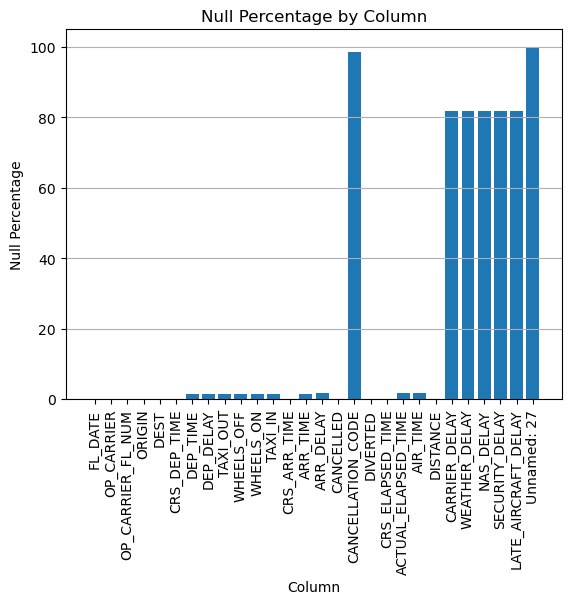

In [ ]:
import matplotlib.pyplot as plt

# Example: Visualizing null percentages
null_counts = summary_df_all.select(["Column", "Null Percentage"]).toPandas()
plt.bar(null_counts["Column"], null_counts["Null Percentage"])
plt.xticks(rotation=90)
plt.title("Null Percentage by Column")
plt.xlabel("Column")
plt.ylabel("Null Percentage")
plt.grid(axis="y")
plt.show()

### Filling Missing Values in CANCELLATION_CODE Column

In [ ]:
# Inspecting CANCELLATION_CODE
df_all.select("CANCELLATION_CODE").distinct().show()

+-----------------+
|CANCELLATION_CODE|
+-----------------+
|                B|
|                C|
|                A|
|                D|
|             NULL|
+-----------------+



In [ ]:
df_all = df_all.fillna("0", subset=["CANCELLATION_CODE"]) # '0' means it is not cancelled

### Filling Missing Values in CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY Columns

In [ ]:
df_all = df_all.fillna(0.0, subset=["CARRIER_DELAY", "WEATHER_DELAY", "NAS_DELAY", "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY"])

In [ ]:
df_all = df_all.drop("Unnamed: 27")

### Dropping Rows with Missing Values

In [ ]:
df_all = df_all.dropna()

In [ ]:
summary_df_all2 = calculate_null_statistics(spark, df_all)
summary_df_all2.show(summary_df_all2.count(), truncate=0)

+-------------------+----------+---------------+
|Column             |Null Count|Null Percentage|
+-------------------+----------+---------------+
|FL_DATE            |0         |0.0            |
|OP_CARRIER         |0         |0.0            |
|OP_CARRIER_FL_NUM  |0         |0.0            |
|ORIGIN             |0         |0.0            |
|DEST               |0         |0.0            |
|CRS_DEP_TIME       |0         |0.0            |
|DEP_TIME           |0         |0.0            |
|DEP_DELAY          |0         |0.0            |
|TAXI_OUT           |0         |0.0            |
|WHEELS_OFF         |0         |0.0            |
|WHEELS_ON          |0         |0.0            |
|TAXI_IN            |0         |0.0            |
|CRS_ARR_TIME       |0         |0.0            |
|ARR_TIME           |0         |0.0            |
|ARR_DELAY          |0         |0.0            |
|CANCELLED          |0         |0.0            |
|CANCELLATION_CODE  |0         |0.0            |
|DIVERTED           

In [ ]:
print("Number of rows in the dataset: ", df_all.count())
print("Number of columns in the dataset: ", len(df_all.columns))

Number of rows in the dataset:  18189372
Number of columns in the dataset:  27


In [ ]:
df = df_all

## Data Visualization and Analysis

In [ ]:
df.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = false)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = false)
 |-- WEATHER_DELAY: do

In [ ]:
# Get top 20 routes with counts
top_20_routes = df.groupBy("ORIGIN", "DEST") \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(20)

# Join the original dataframe with the top 20 routes
joined_df = df.join(top_20_routes, on=["ORIGIN", "DEST"], how="inner")

# Calculate average departure and arrival delays for top 20 routes
avg_delays = joined_df.groupBy("ORIGIN", "DEST") \
    .agg(
        round(avg("DEP_DELAY"), 2).alias("avg_departure_delay"),
        round(avg("ARR_DELAY"), 2).alias("avg_arrival_delay")    ) \
    .orderBy("avg_arrival_delay", ascending=False)

avg_delays.show()

+------+----+-------------------+-----------------+
|ORIGIN|DEST|avg_departure_delay|avg_arrival_delay|
+------+----+-------------------+-----------------+
|   LAX| SFO|              16.81|            14.42|
|   SFO| LAX|               12.3|            12.79|
|   ORD| LGA|              15.49|            12.71|
|   SFO| SEA|              12.28|            10.88|
|   SEA| SFO|              13.91|            10.29|
|   LAS| LAX|              10.09|             8.93|
|   ORD| LAX|               14.4|             6.97|
|   LAX| LAS|               9.84|             6.91|
|   ATL| LGA|              14.07|             6.27|
|   LGA| ORD|              12.75|             5.82|
|   ATL| MCO|               9.65|             5.32|
|   LAX| JFK|              13.44|             4.25|
|   SEA| LAX|               6.27|             4.12|
|   LAX| SEA|               6.19|             3.25|
|   MCO| ATL|               7.26|             2.02|
|   LAX| ORD|               9.34|              2.0|
|   LGA| ATL

### Top 20 Routes by Number of Flights in 2016-2018

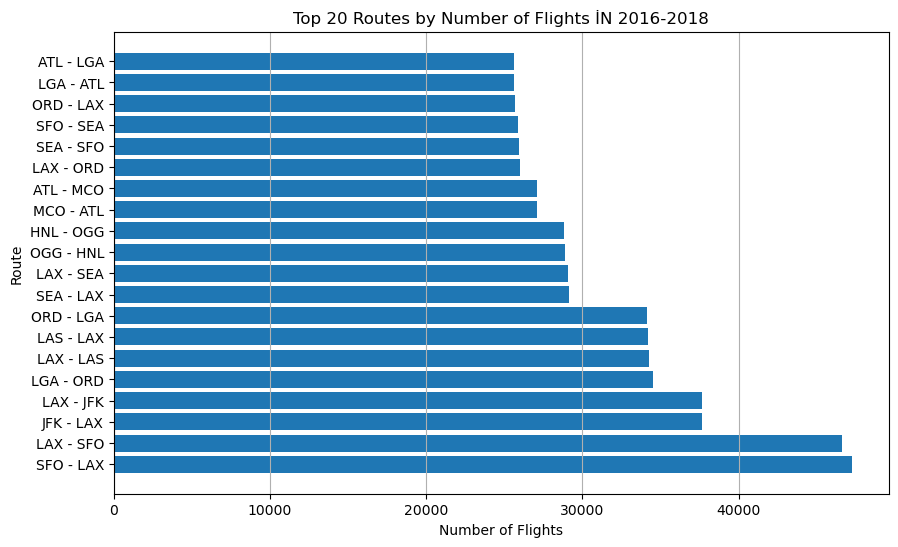

In [ ]:
# Plot the top 20 routes by number of flights
top_20_route_pd = top_20_routes.toPandas()
plt.figure(figsize=(10, 6))
plt.barh(top_20_route_pd["ORIGIN"] + " - " + top_20_route_pd["DEST"], top_20_route_pd["count"])
plt.xlabel("Number of Flights")
plt.ylabel("Route")
plt.title("Top 20 Routes by Number of Flights İN 2016-2018")
plt.grid(axis="x")
plt.show()

### Average Departure Delay by Route (Top 20) in 2016-2018

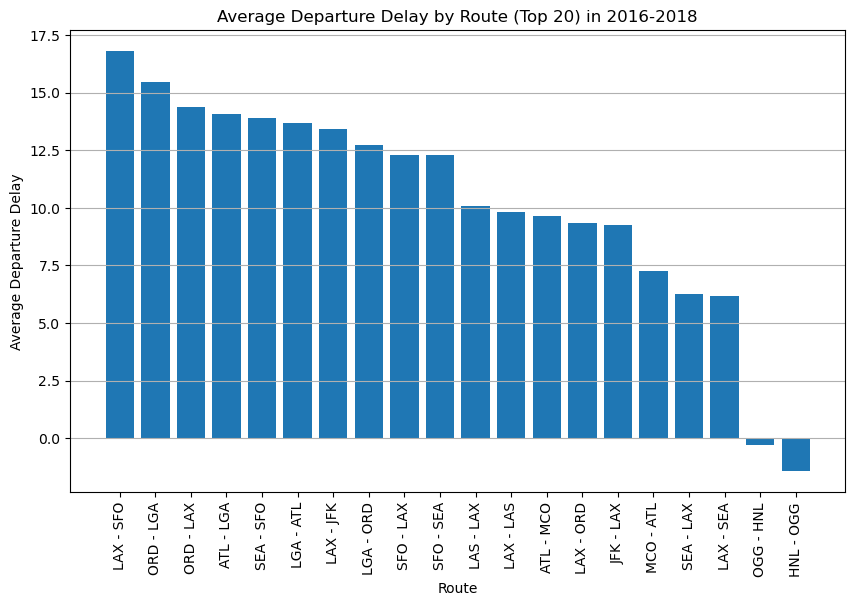

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(avg_delays.toPandas()["ORIGIN"] + " - " + avg_delays.toPandas()["DEST"],
        avg_delays.toPandas()["avg_departure_delay"])
plt.xticks(rotation=90)
plt.title("Average Departure Delay by Route (Top 20) in 2016-2018")
plt.xlabel("Route")
plt.ylabel("Average Departure Delay")
plt.grid(axis="y") 
plt.show()


### Average Arrival Delay by Route (Top 20) in 2016-2018

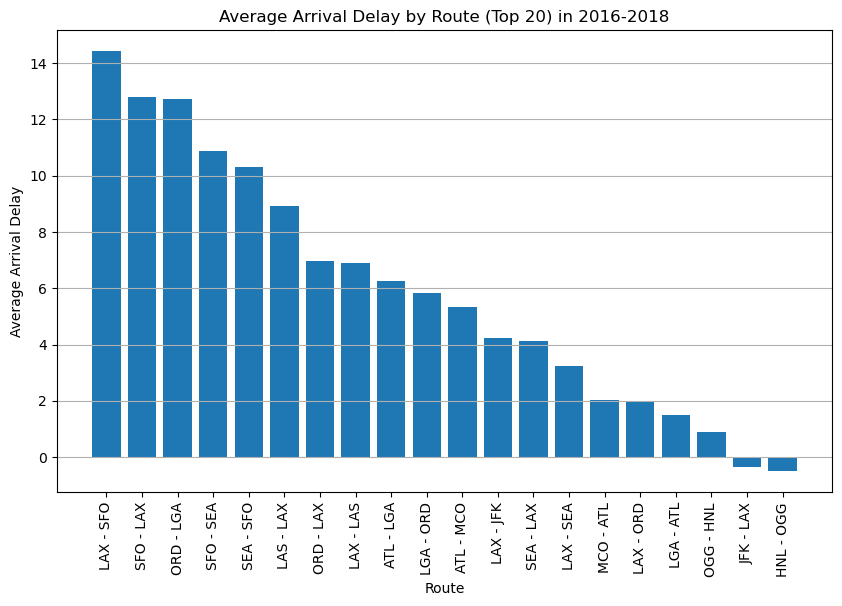

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(avg_delays.toPandas()["ORIGIN"] + " - " + avg_delays.toPandas()["DEST"],
        avg_delays.toPandas()["avg_arrival_delay"])
plt.xticks(rotation=90)
plt.title("Average Arrival Delay by Route (Top 20) in 2016-2018")
plt.xlabel("Route")
plt.ylabel("Average Arrival Delay")
plt.grid(axis="y")
plt.show()

### Taxi-In and Taxi-Out Time Analysis

In [ ]:
# Getting the top 20 routes with the most number of flights
top_20_routes = df.groupBy("ORIGIN", "DEST") \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(20)

# Calculate average taxi_out times for each origin
avg_taxi_out = df.join(top_20_routes, on=["ORIGIN", "DEST"], how="inner") \
    .groupBy("ORIGIN") \
    .agg(
        round(avg("TAXI_OUT"), 2).alias("avg_taxi_out")
    )

# Calculate average taxi_in times for each destination
avg_taxi_in = df.join(top_20_routes, on=["ORIGIN", "DEST"], how="inner") \
    .groupBy("DEST") \
    .agg(
        round(avg("TAXI_IN"), 2).alias("avg_taxi_in")
    )

print("Average Taxi-Out Times by Origin:")
avg_taxi_out.show()

print("Average Taxi-In Times by Destination:")
avg_taxi_in.show()

Average Taxi-Out Times by Origin:


+------+------------+
|ORIGIN|avg_taxi_out|
+------+------------+
|   HNL|       13.19|
|   LGA|       25.73|
|   LAS|       20.12|
|   SEA|       19.37|
|   SFO|       22.26|
|   ATL|        16.5|
|   ORD|       20.61|
|   LAX|        19.6|
|   MCO|       16.63|
|   JFK|       26.53|
|   OGG|        7.86|
+------+------------+

Average Taxi-In Times by Destination:


+----+-----------+
|DEST|avg_taxi_in|
+----+-----------+
| HNL|       7.25|
| LGA|       7.95|
| LAS|       7.46|
| SEA|       9.48|
| SFO|       7.46|
| ATL|       8.75|
| ORD|      13.43|
| LAX|      13.24|
| MCO|       8.85|
| JFK|       9.44|
| OGG|       6.49|
+----+-----------+



In [ ]:
# PySpark DataFrames to Pandas for plotting
avg_taxi_out_pd = avg_taxi_out.toPandas()
avg_taxi_in_pd = avg_taxi_in.toPandas()

# Merge the two datasets on ORIGIN/DEST for route-based visualization
merged_data = avg_taxi_out_pd.rename(columns={"ORIGIN": "ROUTE"}) \
    .merge(avg_taxi_in_pd.rename(columns={"DEST": "ROUTE"}), on="ROUTE", how="inner")

merged_data["ROUTE"] = merged_data["ROUTE"]  # Combine for clear labeling
merged_data = merged_data[["ROUTE", "avg_taxi_out", "avg_taxi_in"]]

x = merged_data["ROUTE"]
avg_taxi_out = merged_data["avg_taxi_out"]
avg_taxi_in = merged_data["avg_taxi_in"]

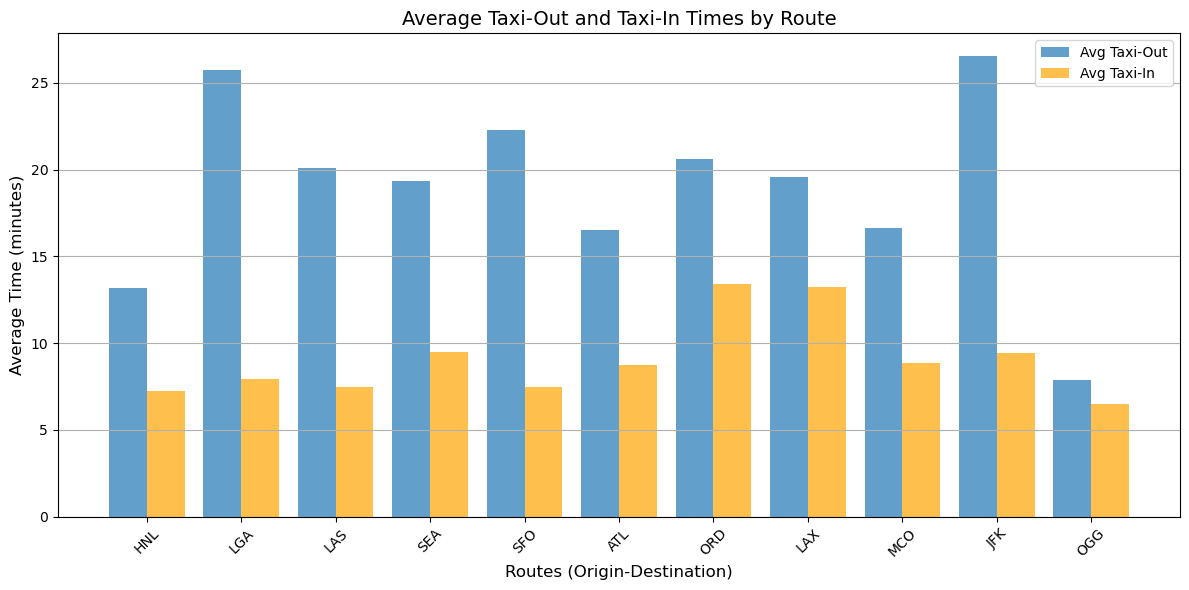

In [ ]:
plt.figure(figsize=(12, 6))
bar_width = 0.4
x_positions = range(len(x))

plt.bar(x_positions, avg_taxi_out, width=bar_width, label="Avg Taxi-Out", alpha=0.7)
plt.bar([p + bar_width for p in x_positions], avg_taxi_in, width=bar_width, label="Avg Taxi-In", alpha=0.7, color='orange')

# Adding labels, title, and legend
plt.xticks([p + bar_width / 2 for p in x_positions], x, rotation=45)
plt.xlabel("Routes (Origin-Destination)", fontsize=12)
plt.ylabel("Average Time (minutes)", fontsize=12)
plt.title("Average Taxi-Out and Taxi-In Times by Route", fontsize=14)
plt.legend()
plt.tight_layout()

plt.grid(axis="y")
# Display the plot
plt.show()

### Flight Volumes of Airlines in 2016-2018

- IATA_CODE,AIRLINE,ShortName
- UA,United Air Lines Inc.,United Airlines
- AA,American Airlines Inc., American Airlines
- US,US Airways Inc., US Airways
- F9,Frontier Airlines Inc., Frontier Airlines
- B6,JetBlue Airways, JetBlue
- OO,Skywest Airlines Inc., Skywest
- AS,Alaska Airlines Inc., Alaska Airlines
- WN,Southwest Airlines Co., Southwest
- DL,Delta Air Lines Inc., Delta
- EV,Atlantic Southeast Airlines, Atlantic Southeast
- MQ,American Eagle Airlines Inc., American Eagle
- HA,Hawaiian Airlines Inc., Hawaiian Airlines
- OH,Comair Airlines, Comair
- YV,Mesa Airlines, Mesa
- FL,AirTran Airways, AirTran
- CO,Continental Airlines, Continental
- 9E,Pinnacle Airlines, Pinnacle
- NW,Northwest Airlines, Northwest
- XE,ExpressJet Airlines, ExpressJet

In [ ]:
# Number of Flight for each OP_CARRIER
number_of_flights_per_carrier = df.groupBy("OP_CARRIER").count().orderBy("count", ascending=False)

number_of_flights_per_carrier.show()

# Plot the number of flights for each OP_CARRIER
number_of_flights_per_carrier_pd = number_of_flights_per_carrier.toPandas()

In [ ]:
def mapper(x):
    dct = {
        "UA": "United Airlines",
        "AA": "American Airlines",
        "US": "US Airways",
        "F9": "Frontier Airlines",
        "B6": "JetBlue",
        "OO": "Skywest",
        "AS": "Alaska Airlines",
        "WN": "Southwest",
        "DL": "Delta",
        "EV": "Atlantic Southeast",
        "MQ": "American Eagle",
        "HA": "Hawaiian Airlines",
        "OH": "Comair",
        "YV": "Mesa",
        "FL": "AirTran",
        "CO": "Continental",
        "9E": "Pinnacle",
        "NW": "Northwest",
        "XE": "ExpressJet",
        "NK": "Spirit Airlines",
        "YX": "Republic Airways",
        "VX": "Virgin America",
        "G4": "Allegiant Air",  }
    return dct[x]

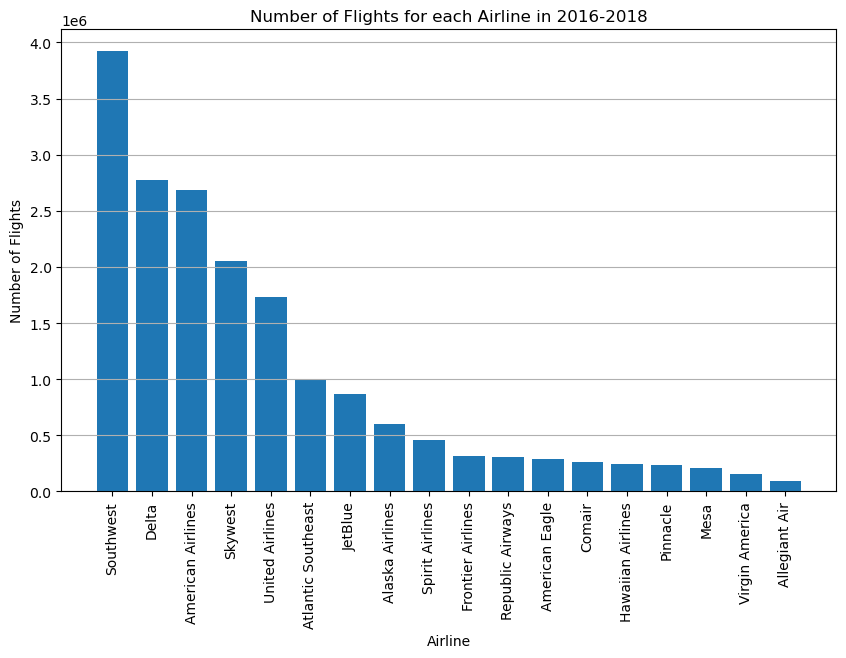

In [ ]:
number_of_flights_per_carrier_pd["AIRLINE_NAME"] = number_of_flights_per_carrier_pd["OP_CARRIER"].apply(mapper)
plt.figure(figsize=(10, 6))
plt.bar(number_of_flights_per_carrier_pd["AIRLINE_NAME"], number_of_flights_per_carrier_pd["count"])
plt.xticks(rotation=90)
plt.xlabel("Airline")
plt.ylabel("Number of Flights")
plt.title("Number of Flights for each Airline in 2016-2018")
plt.grid(axis="y")
plt.show()

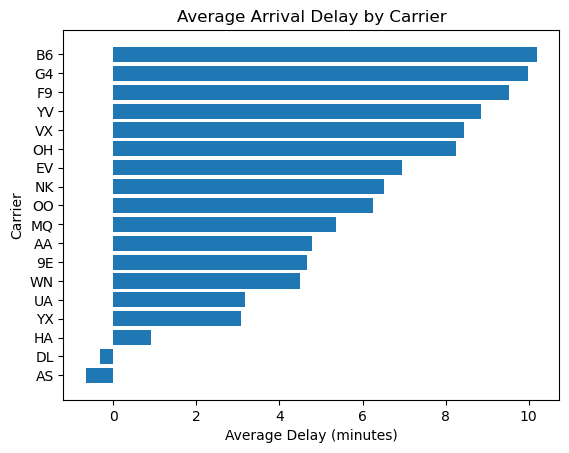

In [ ]:
carrier_data = df.groupBy("OP_CARRIER").agg({"ARR_DELAY": "avg"}).toPandas()
carrier_data.sort_values("avg(ARR_DELAY)", inplace=True)

plt.barh(carrier_data["OP_CARRIER"], carrier_data["avg(ARR_DELAY)"])
plt.title("Average Arrival Delay by Carrier")
plt.xlabel("Average Delay (minutes)")
plt.ylabel("Carrier")
plt.show()

### Southwest Airlines Flight Volume Analysis with Top 10 Routes

In [ ]:
# Southwest Airlines TOP-10 Routes by Number of Flights
southwest_airlines = df.filter(col("OP_CARRIER") == "WN")

southwest_airlines_top_10_routes = southwest_airlines.groupBy("ORIGIN", "DEST").count().orderBy("count", ascending=False).limit(10)

southwest_airlines_top_10_routes.show()

+------+----+-----+
|ORIGIN|DEST|count|
+------+----+-----+
|   HOU| DAL|19131|
|   DAL| HOU|19109|
|   OAK| LAX|12829|
|   LAX| OAK|12811|
|   OAK| BUR|12056|
|   BUR| OAK|12040|
|   SAN| OAK|11509|
|   OAK| SAN|11508|
|   SJC| SAN|11166|
|   SAN| SJC|11130|
+------+----+-----+



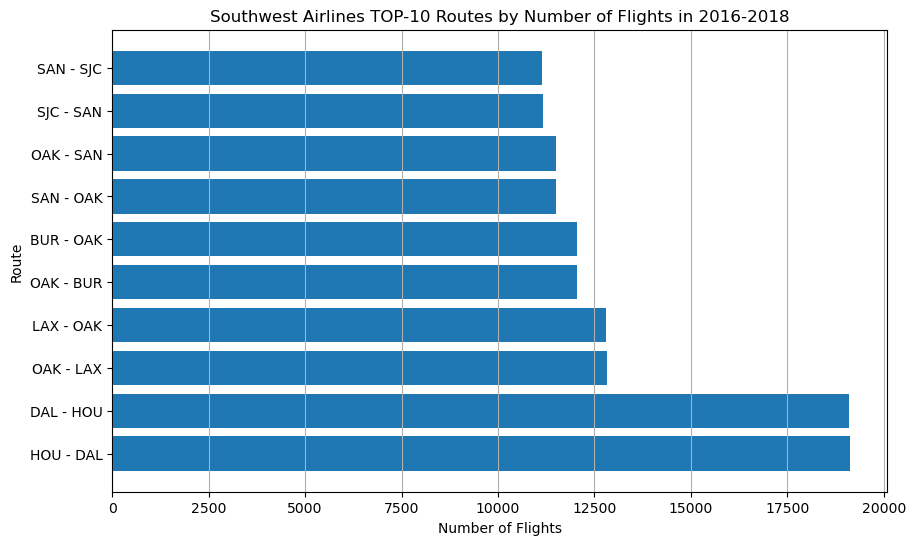

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(southwest_airlines_top_10_routes.toPandas()["ORIGIN"] + " - " + southwest_airlines_top_10_routes.toPandas()["DEST"], southwest_airlines_top_10_routes.toPandas()["count"])
plt.xlabel("Number of Flights")
plt.ylabel("Route")
plt.title("Southwest Airlines TOP-10 Routes by Number of Flights in 2016-2018")
plt.grid(axis="x")
plt.show()

### Southwest Airlines Flight Volume Analysis according to the Months

In [ ]:
# Southwest Flight Number per Month
southwest_airlines = southwest_airlines.withColumn("MONTH", month("FL_DATE"))

southwest_airlines_monthly = southwest_airlines.groupBy("MONTH").count().orderBy("MONTH")

southwest_airlines_monthly.show()

+-----+------+
|MONTH| count|
+-----+------+
|    1|313570|
|    2|284678|
|    3|337426|
|    4|330613|
|    5|336539|
|    6|338457|
|    7|345788|
|    8|335566|
|    9|311303|
|   10|330588|
|   11|326116|
|   12|330468|
+-----+------+



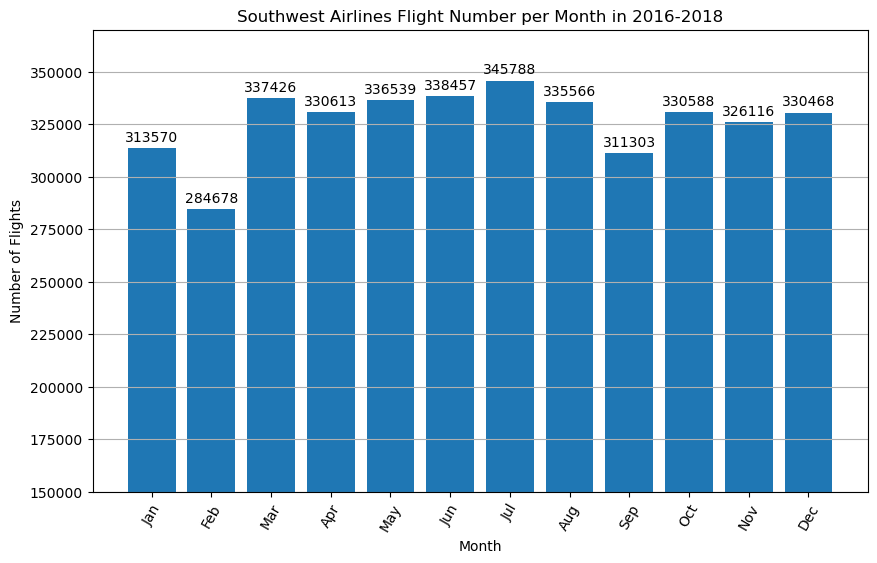

25/01/05 01:36:20 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 525883 ms exceeds timeout 120000 ms
25/01/05 01:36:20 WARN SparkContext: Killing executors is not supported by current scheduler.
25/01/05 01:36:26 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [ ]:
southwest_airlines_monthly_pd = southwest_airlines_monthly.toPandas()

import calendar
month2str = {i: calendar.month_abbr[i] for i in range(1, 13)}

southwest_airlines_monthly_pd["MONTH"] = southwest_airlines_monthly_pd["MONTH"].apply(lambda x: month2str[x])

plt.figure(figsize=(10, 6))
plt.bar(southwest_airlines_monthly_pd["MONTH"], southwest_airlines_monthly_pd["count"])
plt.xlabel("Month")
plt.ylabel("Number of Flights")
plt.title("Southwest Airlines Flight Number per Month in 2016-2018")

for i, txt in enumerate(southwest_airlines_monthly_pd["count"]):
    plt.annotate(txt, (southwest_airlines_monthly_pd["MONTH"][i], southwest_airlines_monthly_pd["count"][i]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.xticks(rotation=60)
plt.ylim(1.5e5, 3.7e5)
plt.grid(axis="y")
plt.show()

### Monthly Flight Volume Analysis of Airlines in 2016-2018

In [ ]:
monthly_avg_delay = df.withColumn("MONTH", month("FL_DATE")).groupBy("MONTH").agg({"ARR_DELAY": "avg"}).orderBy("MONTH")

monthly_avg_delay.show()

+-----+------------------+
|MONTH|    avg(ARR_DELAY)|
+-----+------------------+
|    1| 3.714185390792611|
|    2|1.8329488232939342|
|    3|3.0806097440221905|
|    4| 3.862221332922069|
|    5| 4.812200988301412|
|    6| 8.290893542410801|
|    7|  9.24413298164471|
|    8| 8.278980063976299|
|    9|1.0720231942210179|
|   10|1.4037450468983736|
|   11|0.5211419983552131|
|   12| 5.027310078897863|
+-----+------------------+



In [ ]:
orig_airport_crowdedness = df.withColumn("MONTH", month("FL_DATE")).groupBy("MONTH").count().orderBy("MONTH")

orig_airport_crowdedness.show()

+-----+-------+
|MONTH|  count|
+-----+-------+
|    1|1423965|
|    2|1328964|
|    3|1545173|
|    4|1504304|
|    5|1563693|
|    6|1580977|
|    7|1624164|
|    8|1617474|
|    9|1471401|
|   10|1553572|
|   11|1479827|
|   12|1495858|
+-----+-------+



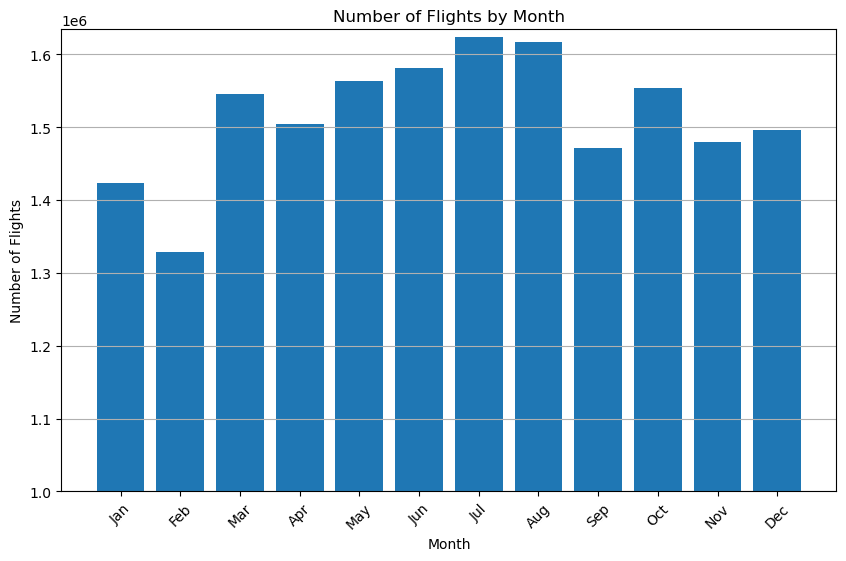

In [ ]:
# Plot the crowdedness of the ORIG airport by month
import calendar
month2str = {i: calendar.month_abbr[i] for i in range(1, 13)}

orig_airport_crowdedness_pd = orig_airport_crowdedness.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(orig_airport_crowdedness_pd["MONTH"], orig_airport_crowdedness_pd["count"])
plt.xticks(orig_airport_crowdedness_pd["MONTH"], [month2str[m] for m in orig_airport_crowdedness_pd["MONTH"]], rotation=45)
plt.ylim(1e6, orig_airport_crowdedness_pd["count"].max() + 10000)
plt.xlabel("Month")
plt.ylabel("Number of Flights")
plt.title("Number of Flights by Month")
plt.grid(axis="y")
plt.show()

### Top-20 Airport According to the Number of Flights in 2016-2018

In [ ]:
# En yoğun havaalanları analizi
top_20_airports = df.groupBy("ORIGIN").count().orderBy("count", ascending=False).limit(20)

top_20_airports.show()

+------+-------+
|ORIGIN|  count|
+------+-------+
|   ATL|1125502|
|   ORD| 826390|
|   DEN| 677307|
|   DFW| 645433|
|   LAX| 641315|
|   SFO| 513398|
|   PHX| 483470|
|   LAS| 458871|
|   CLT| 447607|
|   IAH| 431991|
|   MSP| 418336|
|   SEA| 406818|
|   DTW| 402802|
|   MCO| 389434|
|   BOS| 385546|
|   EWR| 364093|
|   LGA| 347025|
|   SLC| 331450|
|   JFK| 313481|
|   BWI| 297645|
+------+-------+



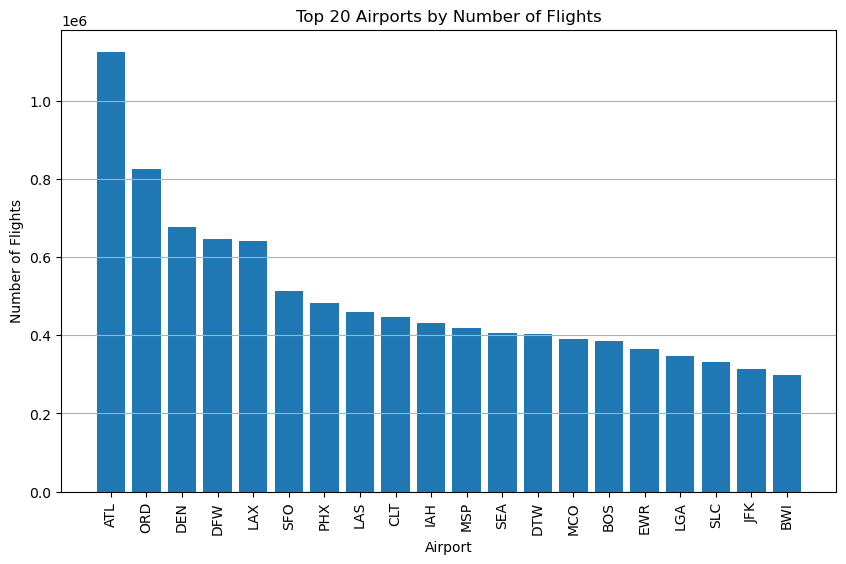

In [ ]:
plt.figure(figsize=(10, 6))
top_20_airports_pd = top_20_airports.toPandas()
plt.bar(top_20_airports_pd["ORIGIN"], top_20_airports_pd["count"])
plt.xlabel("Airport")
plt.ylabel("Number of Flights")
plt.title("Top 20 Airports by Number of Flights")
plt.grid(axis="y")
plt.xticks(rotation=90)
plt.show()


### Montly Flight Delay Analysis in 2016-2018

In [ ]:
import pyspark.sql.functions as F
from pyspark.sql.window import Window

# Convert Spark DataFrame to Pandas
monthly_delay_pd = df.withColumn("MONTH", F.month("FL_DATE")).groupBy("MONTH").agg({"DEP_DELAY": "avg"}).orderBy("MONTH").toPandas()
# Verify data
print("Data shape:", monthly_delay_pd.shape)
print("\nFirst few rows:")
print(monthly_delay_pd.head())

Data shape: (12, 2)

First few rows:
   MONTH  avg(DEP_DELAY)
0      1        9.713130
1      2        8.021691
2      3        8.323632
3      4        8.850637
4      5        9.647460


In [ ]:
# Calculate monthly statistics
monthly_stats = df.withColumn("MONTH", F.month("FL_DATE")) \
    .groupBy("MONTH") \
    .agg(
        F.mean("DEP_DELAY").alias("mean_delay"),
        F.expr("percentile_approx(DEP_DELAY, 0.5)").alias("median_delay"),
        F.stddev("DEP_DELAY").alias("std_delay"),
        F.expr("percentile_approx(DEP_DELAY, 0.25)").alias("q1_delay"),
        F.expr("percentile_approx(DEP_DELAY, 0.75)").alias("q3_delay")
    ) \
    .orderBy("MONTH")

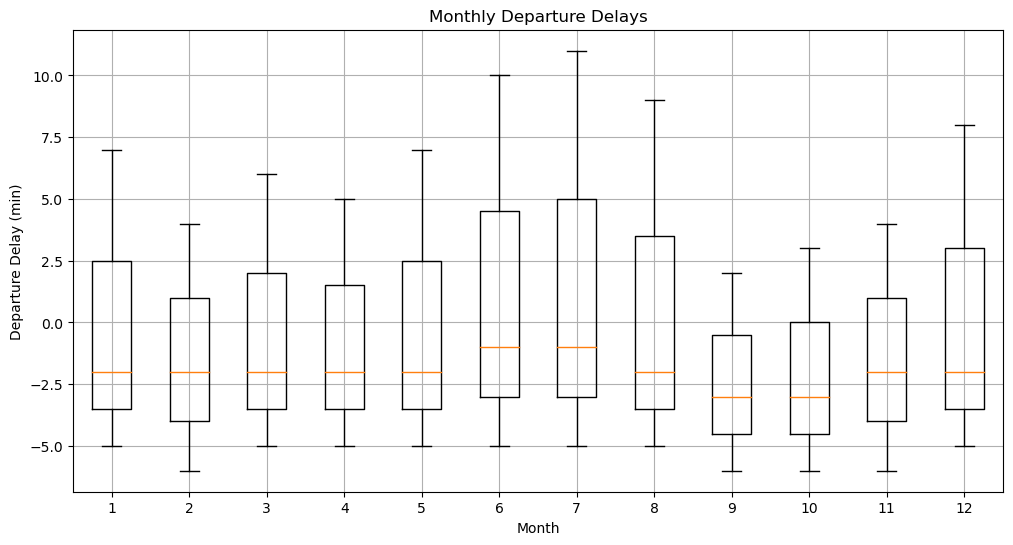

In [ ]:
# Prepare data for boxplot
data = monthly_stats.toPandas()
boxplot_data = {
    month: [data["q1_delay"][i], data["median_delay"][i], data["q3_delay"][i]]
    for i, month in enumerate(data["MONTH"])
}

# Boxplot visualization
plt.figure(figsize=(12, 6))
plt.boxplot(boxplot_data.values(), labels=boxplot_data.keys())
plt.title("Monthly Departure Delays")
plt.xlabel("Month")
plt.ylabel("Departure Delay (min)")
plt.grid(True)
plt.show()

### Monthly Flight Delay Analysis of Atlanta Airport in 2016-2018

In [ ]:
# Calculate monthly statistics
monthly_stats_ATL = df.withColumn("MONTH", F.month("FL_DATE")) \
    .filter(F.col("ORIGIN") == "ATL") \
    .groupBy("MONTH") \
    .agg(
        F.mean("DEP_DELAY").alias("mean_delay"),
        F.expr("percentile_approx(DEP_DELAY, 0.5)").alias("median_delay"),
        F.stddev("DEP_DELAY").alias("std_delay"),
        F.expr("percentile_approx(DEP_DELAY, 0.25)").alias("q1_delay"),
        F.expr("percentile_approx(DEP_DELAY, 0.75)").alias("q3_delay")
    ) \
    .orderBy("MONTH")

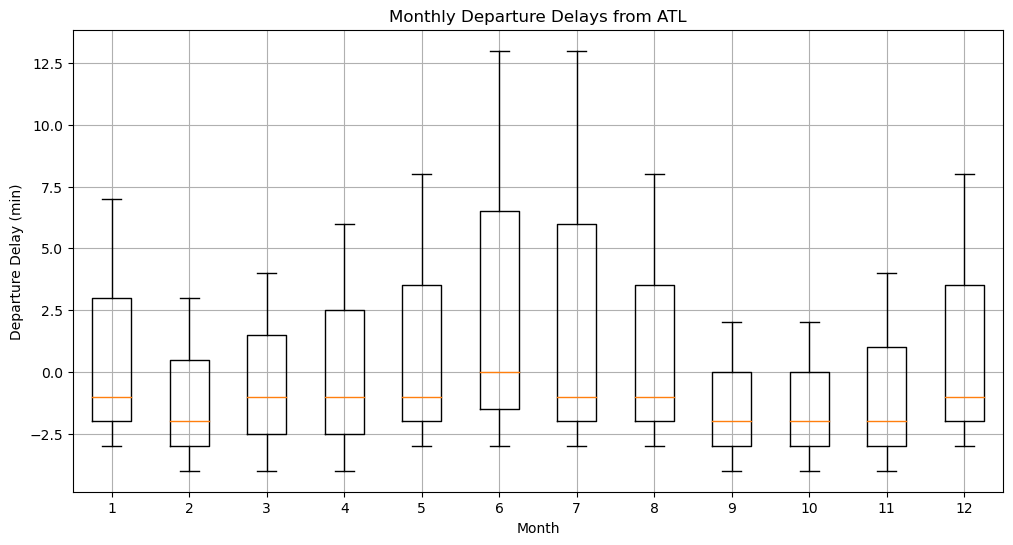

In [ ]:
data_ATL = monthly_stats_ATL.toPandas()

boxplot_data_ATL = {
    month: [data_ATL["q1_delay"][i], data_ATL["median_delay"][i], data_ATL["q3_delay"][i]]
    for i, month in enumerate(data_ATL["MONTH"])
}

# Boxplot visualization
plt.figure(figsize=(12, 6))
plt.boxplot(boxplot_data_ATL.values(), labels=boxplot_data_ATL.keys())
plt.title("Monthly Departure Delays from ATL")
plt.xlabel("Month")
plt.ylabel("Departure Delay (min)")
plt.grid(True)
plt.show()


### Dynamic Visualization of Flight Volume by States in 2016-2018

In [ ]:
import plotly.express as px

# Read the airports.csv file
airport_df = spark.read.csv("Data/airports.csv", header=True, inferSchema=True)

# Alias the airport DataFrame for origin and destination
origin_airport_df = airport_df.alias("origin_data")

# Join origin data with flight data to get state information
df_with_states = df.join(
    origin_airport_df,
    df["ORIGIN"] == origin_airport_df["IATA_CODE"],
    "left"
)

# Group by state and count flights
state_flight_counts = (
    df_with_states.groupBy("origin_data.STATE")
    .agg(count("*").alias("Flight_Count"))
    .toPandas()
)

# Visualization using Plotly
fig = px.choropleth(
    state_flight_counts,
    locations="STATE",  # Use state abbreviations
    locationmode="USA-states",  # Ensure only USA states are plotted
    color="Flight_Count",
    range_color=[state_flight_counts["Flight_Count"].min(), state_flight_counts["Flight_Count"].max()],
    scope="usa",
    title="Flight Volume by State",
    color_continuous_scale="Blues",
)

fig.write_html("state_flight_counts.html")
fig.show()

### Dynamic Visualization of Flight Delays by States in 2016-2018

In [ ]:
import plotly.express as px


airport_df = spark.read.csv("Data/airports.csv", header=True, inferSchema=True)

# Alias the airport DataFrame
origin_airport_df = airport_df.alias("origin_data")
dest_airport_df = airport_df.alias("dest_data")

# Join origin and destination data with flight data
df_with_airports = (
    df.join(origin_airport_df, df["ORIGIN"] == origin_airport_df["IATA_CODE"], "left")
      .join(dest_airport_df, df["DEST"] == dest_airport_df["IATA_CODE"], "left")
)

# Group by state (using the origin airport state)
state_delays = (
    df_with_airports.groupBy("origin_data.STATE")
    .agg(avg("DEP_DELAY").alias("Avg_Dep_Delay"))
    .toPandas()
)

# Visualization using Plotly
fig = px.choropleth(
    state_delays,
    locations="STATE",  # Use state abbreviations
    locationmode="USA-states",  # Ensure only USA states are plotted
    color="Avg_Dep_Delay",
    range_color=[0, 20],  # Adjust range as needed
    scope="usa",
    title="Average Flight Delays by State",
    color_continuous_scale="Reds",
)

fig.write_html("state_delays.html")
fig.show()

## Model Training for Delay Prediction in minutes

In [ ]:
# String Indexer for OP_CARRIER 
indexer = StringIndexer(inputCol="OP_CARRIER", outputCol="OP_CARRIER_INDEX")
indexed = indexer.fit(df).transform(df)

# One Hot Encoder for OP_CARRIER
encoder = OneHotEncoder(inputCol="OP_CARRIER_INDEX", outputCol="OP_CARRIER_VEC")
encoded = encoder.fit(indexed).transform(indexed)

# String Indexer for ORIGIN
indexer = StringIndexer(inputCol="ORIGIN", outputCol="ORIGIN_INDEX")
indexed = indexer.fit(encoded).transform(encoded)

# One Hot Encoder for ORIGIN
encoder = OneHotEncoder(inputCol="ORIGIN_INDEX", outputCol="ORIGIN_VEC")
encoded = encoder.fit(indexed).transform(indexed)

# String Indexer for DEST
indexer = StringIndexer(inputCol="DEST", outputCol="DEST_INDEX")
indexed = indexer.fit(encoded).transform(encoded)

# One Hot Encoder for DEST
encoder = OneHotEncoder(inputCol="DEST_INDEX", outputCol="DEST_VEC")
encoded = encoder.fit(indexed).transform(indexed)

In [ ]:
encoded.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = false)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = false)
 |-- WEATHER_DELAY: do

In [ ]:
# indexed = indexed.withColumn("IS_CARRIER_DELAY", when(col("CARRIER_DELAY") > 0, 1).otherwise(0))
# indexed = indexed.withColumn("IS_WEATHER_DELAY", when(col("WEATHER_DELAY") > 0, 1).otherwise(0))
# indexed = indexed.withColumn("IS_NAS_DELAY", when(col("NAS_DELAY") > 0, 1).otherwise(0))
# indexed = indexed.withColumn("IS_SECURITY_DELAY", when(col("SECURITY_DELAY") > 0, 1).otherwise(0))
# indexed = indexed.withColumn("IS_LATE_AIRCRAFT_DELAY", when(col("LATE_AIRCRAFT_DELAY") > 0, 1).otherwise(0))

encoded = encoded.withColumn("IS_CARRIER_DELAY", when(col("CARRIER_DELAY") > 0, 1).otherwise(0))
encoded = encoded.withColumn("IS_WEATHER_DELAY", when(col("WEATHER_DELAY") > 0, 1).otherwise(0))
encoded = encoded.withColumn("IS_NAS_DELAY", when(col("NAS_DELAY") > 0, 1).otherwise(0))
encoded = encoded.withColumn("IS_SECURITY_DELAY", when(col("SECURITY_DELAY") > 0, 1).otherwise(0)) 
encoded = encoded.withColumn("IS_LATE_AIRCRAFT_DELAY", when(col("LATE_AIRCRAFT_DELAY") > 0, 1).otherwise(0))

In [ ]:
features = ["TAXI_OUT", "TAXI_IN", "DIVERTED", "ACTUAL_ELAPSED_TIME", "AIR_TIME", "OP_CARRIER_INDEX", "ORIGIN_INDEX", "DEST_INDEX", "IS_CARRIER_DELAY", "IS_WEATHER_DELAY", "IS_NAS_DELAY", "IS_SECURITY_DELAY", "IS_LATE_AIRCRAFT_DELAY"]

assembler = VectorAssembler(inputCols=features, outputCol="features")
output = assembler.transform(encoded)

output.select("features").show(5, truncate=False)

+-------------------------------------------------------------+
|features                                                     |
+-------------------------------------------------------------+
|(13,[0,1,3,4,5,6,7],[23.0,13.0,285.0,249.0,1.0,12.0,4.0])    |
|(13,[0,1,3,4,5,7],[13.0,4.0,109.0,92.0,1.0,77.0])            |
|(13,[0,1,3,4,5,6],[19.0,5.0,231.0,207.0,1.0,4.0])            |
|(13,[0,1,3,4,5,6],[12.0,8.0,193.0,173.0,1.0,17.0])           |
|[63.0,4.0,0.0,188.0,121.0,1.0,118.0,10.0,1.0,0.0,1.0,0.0,0.0]|
+-------------------------------------------------------------+
only showing top 5 rows



In [ ]:
output.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = false)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = false)
 |-- WEATHER_DELAY: do

In [ ]:
# Linear Regression Model
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Split the data
train, test = output.randomSplit([0.7, 0.3])

# Create a Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="DEP_DELAY")

# Fit the model
lr_model = lr.fit(train)

# Make predictions
predictions = lr_model.transform(test)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="DEP_DELAY", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


24/12/28 17:16:17 WARN Instrumentation: [1123b2b9] regParam is zero, which might cause numerical instability and overfitting.
24/12/28 17:16:46 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/12/28 17:18:11 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
24/12/28 17:18:11 WARN Instrumentation: [1123b2b9] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Root Mean Squared Error (RMSE) on test data = 35.9559


In [10]:
threshold = 2

predictions = predictions.withColumn("is_in_interval", when(abs(col("DEP_DELAY") - col("prediction")) <= threshold, 1).otherwise(0))
total_correct = predictions.filter(col("is_in_interval") == 1).count()
total = predictions.count()

accuracy = total_correct / total
print("Accuracy: ", accuracy)

[Stage 200:===========================================>           (19 + 5) / 24]
Accuracy:  0.236781213


In [11]:
threshold = 3

predictions = predictions.withColumn("is_in_interval", when(abs(col("DEP_DELAY") - col("prediction")) <= threshold, 1).otherwise(0))
total_correct = predictions.filter(col("is_in_interval") == 1).count()
total = predictions.count()

accuracy = total_correct / total
print("Accuracy: ", accuracy)

[Stage 203:===========================================>           (19 + 5) / 24]
Accuracy:  0.361781213


In [12]:
threshold = 5

predictions = predictions.withColumn("is_in_interval", when(abs(col("DEP_DELAY") - col("prediction")) <= threshold, 1).otherwise(0))
total_correct = predictions.filter(col("is_in_interval") == 1).count()
total = predictions.count()

accuracy = total_correct / total
print("Accuracy: ", accuracy)

[Stage 206:===========================================>           (19 + 5) / 24]
Accuracy:  0.491781213


In [13]:
threshold = 7.5

predictions = predictions.withColumn("is_in_interval", when(abs(col("DEP_DELAY") - col("prediction")) <= threshold, 1).otherwise(0))
total_correct = predictions.filter(col("is_in_interval") == 1).count()
total = predictions.count()

accuracy = total_correct / total
print("Accuracy: ", accuracy)

[Stage 209:===========================================>           (19 + 5) / 24]
Accuracy:  0.621781213


In [1]:
from pyspark.ml.regression import RandomForestRegressor

# Create a Random Forest model
rf = RandomForestRegressor(featuresCol="features", labelCol="DEP_DELAY", maxBins=360)

# Fit the model
rf_model = rf.fit(train)

# Make predictions
predictions = rf_model.transform(test)

# Evaluate the model
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

24/12/28 17:39:29 WARN MemoryStore: Not enough space to cache rdd_965_21 in memory! (computed 100.6 MiB so far)
24/12/28 17:39:29 WARN MemoryStore: Not enough space to cache rdd_965_20 in memory! (computed 100.6 MiB so far)
24/12/28 17:39:29 WARN BlockManager: Persisting block rdd_965_21 to disk instead.
24/12/28 17:39:29 WARN BlockManager: Persisting block rdd_965_20 to disk instead.
                                                                                
Root Mean Squared Error (RMSE) on test data = 30.5171


In [3]:
threshold = 2

predictions = predictions.withColumn("is_in_interval", when(abs(col("DEP_DELAY") - col("prediction")) <= threshold, 1).otherwise(0))
total_correct = predictions.filter(col("is_in_interval") == 1).count()

accuracy = total_correct / total
print("Accuracy: ", accuracy)

[Stage 227:===========================================>           (19 + 5) / 24]
Accuracy:  0.4522104092194184


In [5]:
threshold = 3

predictions = predictions.withColumn("is_in_interval", when(abs(col("DEP_DELAY") - col("prediction")) <= threshold, 1).otherwise(0))
total_correct = predictions.filter(col("is_in_interval") == 1).count()

accuracy = total_correct / total
print("Accuracy: ", accuracy)

[Stage 230:===========================================>           (19 + 5) / 24]
Accuracy:  0.56113371241425


In [7]:
threshold = 5

predictions = predictions.withColumn("is_in_interval", when(abs(col("DEP_DELAY") - col("prediction")) <= threshold, 1).otherwise(0))
total_correct = predictions.filter(col("is_in_interval") == 1).count()

accuracy = total_correct / total
print("Accuracy: ", accuracy)

[Stage 233:===========================================>           (19 + 5) / 24]
Accuracy:  0.676712311353


In [8]:
threshold = 7.5

predictions = predictions.withColumn("is_in_interval", when(abs(col("DEP_DELAY") - col("prediction")) <= threshold, 1).otherwise(0))
total_correct = predictions.filter(col("is_in_interval") == 1).count()

accuracy = total_correct / total
print("Accuracy: ", accuracy)

[Stage 236:===========================================>           (19 + 5) / 24]
Accuracy:  0.71467123
